In [1]:
pip install pymc3

  Using cached https://files.pythonhosted.org/packages/42/c2/86e8be42b99d64932fa12611b502882a5f4d834b6d1d126bf3f956ad6428/pymc3-3.7-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7d/c4/6341148ad458b6cd8361b774d7ee6895c38eab88f05331f22304c484ed5d/Theano-1.0.4.tar.gz
  Stored in directory: C:\Users\Praveen\AppData\Local\pip\Cache\wheels\88\fb\be\483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built theano
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy

# PyMC3 for Bayesian Inference
import pymc3 as pm

#other functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
np.random.seed(42)
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)
from IPython.core.pylabtools import figsize
from scipy.stats import percentileofscore
from scipy import stats

In [2]:
df = pd.read_csv('realestate.csv')
df.head()

,AGE,MRT,STORES,PRICE
0,32.0,84.87882,10,37.9
1,19.5,306.59470,9,42.2
2,13.3,561.98450,5,47.3
3,13.3,561.98450,5,54.8
4,5.0,390.56840,5,43.1


In [9]:
labels = df['PRICE']
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size = 0.25, random_state=42)
X_train.head()

,AGE,MRT,STORES,PRICE
326,4.1,56.47425,7,62.1
410,5.6,90.45606,9,50.0
391,6.2,1939.74900,1,31.3
352,18.4,2674.96100,3,25.7
132,26.6,482.75810,5,37.5


In [10]:
print(X_train.shape)
print(X_test.shape)

(310, 4)
(104, 4)


In [12]:
#define the formula
formula = 'PRICE ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[:-1]])
formula

'PRICE ~ AGE + MRT + STORES'

In [ ]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=300, chains = 1, tune = 1000)

In [37]:
def test_model(trace, test_observation):
    
    # Print out the test observation data
    print('Test Observation:')
    print(test_observation)
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()

    # Actual Value
    actual = test_observation['PRICE']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('PRICE')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of grade
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    # Plot all the estimates
    plt.figure(figsize(8, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    # Plot the actual grade
    plt.vlines(x = actual, ymin = 0, ymax = 0.1, 
               linestyles = '--', colors = 'red',
               label = 'True Grade',
              linewidth = 2.5)
    
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 0.1, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('Price'); plt.ylabel('Density');
    
    # Prediction information
    print('True Grade = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

Test Observation:
AGE       32.00000
MRT       84.87882
STORES    10.00000
PRICE     37.90000
Name: 0, dtype: float64


C:\Users\Praveen\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


True Grade = 37
Average Estimate = 48.0810
5% Estimate = 32.0825    95% Estimate = 62.6874


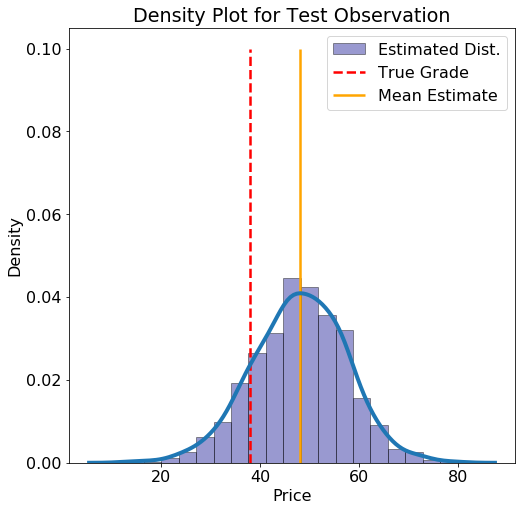

In [39]:
#test for induvidual
test_model(normal_trace, X_test.iloc[42])

In [50]:
#calculate difference between mean and actual value
def meandiff(trace,test_observation):
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()

    # Actual Value
    actual = test_observation['PRICE']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('PRICE')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of grade
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

   
    diff = mean_loc - actual
    return diff

In [54]:
#calculating mean squared error
sum = 0
for i in range(83):
    diff = meandiff(normal_trace, X_test.iloc[i])
    square = diff**2
    sum = sum + square

mean = sum / 83
mse = np.sqrt(mean)
print(mse)

C:\Users\Praveen\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


7.701739925826629


In [53]:
len(X_test)

104